# Imports

In [1]:
import os
import numpy as np
import pandas as pd
from sys import path
from copy import deepcopy
import warnings
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
warnings.filterwarnings("ignore")

model_dir = 'sample_code_submission/'
result_dir = 'sample_result_submission/' 
problem_dir = 'ingestion_program/'  
score_dir = 'scoring_program/'


path.append(model_dir) 
path.append(problem_dir)
path.append(score_dir)
path.append("../Data_Generator")

from data_io import load_data, show_data_statistics, write


data_name = 'fair_universe_challenge'
data_dir = 'sample_data' 


train_sets, test_sets, settings = load_data(data_dir, load_settings=True)



###-------------------------------------###
### Data Loading
###-------------------------------------###

[*] data dir :  sample_data
[*] train data dir :  sample_data/train/data
[*] train labels dir :  sample_data/train/labels
[*] test data dir :  sample_data/test/data
[*] test labels dir :  sample_data/test/labels
[*] settings dir :  sample_data/settings
[+] train data dir found
[+] train labels dir found
[+] test data dir found
[+] test labels dir found
[+] settings dir found
[+] 6 train and test sets found
---------------------------------
[+] Train and Test data loaded!
---------------------------------




In [13]:
# train = train_sets[0]["data"][:10]
# test =  test_sets[0]["data"][:10]

# train_mean = np.mean(train).values
# test_mean = np.mean(test).values

# train_std = np.std(train).values
# test_std = np.std(test).values

# round(test_std[0], 4), round(test_std[1], 4)

# # translation = test_mean- train_mean
# # scaling = test_std/train_std

# # test = (test - translation)/scaling

(1.8407, 0.9987)

In [16]:
# col1 = test["x1"].values
# col2 = test["x2"].values

# col1, col2

# mean1 = np.mean(col1)
# mean2 = np.mean(col2)

# sum1 = np.sum([np.square(item-mean1) for item in col1])
# sum2 = np.sum([np.square(item-mean2) for item in col2])

# n1 = np.sqrt(sum1/10)
# n2 = np.sqrt(sum2/10)

# round(n1,4), round(n2,4)

(1.8407, 0.9987)

In [3]:
from model import Model
from metric import auc_metric, bac_metric

model_settings = [
    {"display_name" : "NB plain", "model_name": "NB", "preprocessing" : False, "data_augmentation" : False},
    {"display_name" : "LDA plain", "model_name": "LDA", "preprocessing" : False, "data_augmentation" : False},
    {"display_name" : "RR plain", "model_name": "RR", "preprocessing" : False, "data_augmentation" : False},
]

#---------------------------------
# Load Data
#---------------------------------
# Train set
X_Trains = [train_set["data"] for train_set in train_sets]
Y_Trains = [train_set["labels"] for train_set in train_sets]

# Test set
X_Tests = [test_set["data"] for test_set in test_sets]
Y_Tests = [test_set["labels"] for test_set in test_sets]


print("############################################")
print("### Training Program")
print("############################################")

#---------------------------------
# Loop over model settings
#---------------------------------
results = []
for model_setting in model_settings:

    print("\n--------------------------------------------")
    print("[*] Model : {} --- Preprocessing: {} --- Data Augmentation: {}".format(model_setting["model_name"], model_setting["preprocessing"], model_setting["data_augmentation"]))
    print("--------------------------------------------")
    #---------------------------------
    # Predictions Directory
    #---------------------------------
    # result directory 
    predictions_dir = os.path.join(result_dir, model_setting["model_name"])
    # create result directory if not created
    if not os.path.exists(predictions_dir):
        os.mkdir(predictions_dir) 

    #---------------------------------
    # Loop over datasets
    #---------------------------------
    trained_models = []
    Y_hat_trains, Y_hat_score_trains = [], []
    Y_hat_tests, Y_hat_score_tests = [], []
    auc_trains, auc_tests, bac_trains, bac_tests = [],[],[],[]
    for index, _ in enumerate(X_Trains):

        print("\n\tDataset : {}".format(index+1))
        print("\t----------------")

      
        
       
        # model_name 
        trained_model_name = model_dir + model_setting["model_name"]

        #---------------------------------
        # Load Model
        #---------------------------------
        print("\t[*] Loading Model")
        model = Model(
            model_setting["model_name"],
            X_Trains[index],
            Y_Trains[index],
            X_Tests[index],
            model_setting["preprocessing"],
            model_setting["data_augmentation"]
        )
        # Load Trained Model 
        # model = model.load(trained_model_name) 

        #---------------------------------
        # Train Model
        #---------------------------------
        # Train model if not trained
        print("\t[*] Training Model")
        if not(model.is_trained):
            model.fit() 

        #---------------------------------
        # Get Predictions
        #---------------------------------
        print("\t[*] Get Predictions")
        Y_hat_trains.append(model.predict(X_Trains[index]))
        Y_hat_tests.append(model.predict())
        
        #---------------------------------
        # Get Scores/Proba
        #---------------------------------
        print("\t[*] Get Scores")
        Y_hat_score_trains.append(model.decision_function(X_Trains[index]))
        Y_hat_score_tests.append(model.decision_function())

        trained_models.append(model)

        #---------------------------------
        # Get Metric Scores
        #---------------------------------
        print("\t[*] Computing Scores using AUC and BAC")
        auc_trains.append(round(auc_metric(Y_Trains[index], Y_hat_score_trains[-1]), 5))
        auc_tests.append(round(auc_metric(Y_Tests[index], Y_hat_score_tests[-1]), 5))
        bac_trains.append(round(bac_metric(Y_Trains[index], Y_hat_trains[-1]), 5))
        bac_tests.append(round(bac_metric(Y_Tests[index], Y_hat_tests[-1]), 5))


        #---------------------------------
        # Save Predictions
        #---------------------------------
        print("\t[*] Saving Predictions and Scores")
        # prediction file name
        prediction_name_train = os.path.join(predictions_dir, "train_"+ str(index+1) + ".predictions")
        prediction_name_test = os.path.join(predictions_dir, "test_"+ str(index+1) + ".predictions")

        # score file name
        score_name_train = os.path.join(predictions_dir, "train_"+ str(index+1) + ".scores")
        score_name_test = os.path.join(predictions_dir, "test_"+ str(index+1) + ".scores")
        
        # save prediction
        write(prediction_name_train, Y_hat_score_trains[-1])
        write(prediction_name_test, Y_hat_score_tests[-1])

        # save score
        write(score_name_train, Y_hat_score_trains[-1])
        write(score_name_test, Y_hat_score_tests[-1])
    


    
    results.append({
        "trained_models" : trained_models,
        "Y_hat_trains" : Y_hat_trains,
        "Y_hat_tests" : Y_hat_tests,
        "Y_hat_score_trains" : Y_hat_score_trains,
        "Y_hat_score_tests" : Y_hat_score_tests,
        "auc_trains" : auc_trains,
        "auc_tests" : auc_tests,
        "bac_trains" : bac_trains,
        "bac_tests" : bac_tests,
    })

############################################
### Training Program
############################################

--------------------------------------------
[*] Model : NB --- Preprocessing: False --- Data Augmentation: False
--------------------------------------------

	Dataset : 1
	----------------
	[*] Loading Model
	[*] Training Model
	[*] Get Predictions
	[*] Get Scores
	[*] Computing Scores using AUC and BAC
	[*] Saving Predictions and Scores

	Dataset : 2
	----------------
	[*] Loading Model
	[*] Training Model
	[*] Get Predictions
	[*] Get Scores
	[*] Computing Scores using AUC and BAC
	[*] Saving Predictions and Scores

	Dataset : 3
	----------------
	[*] Loading Model
	[*] Training Model
	[*] Get Predictions
	[*] Get Scores
	[*] Computing Scores using AUC and BAC
	[*] Saving Predictions and Scores

	Dataset : 4
	----------------
	[*] Loading Model
	[*] Training Model
	[*] Get Predictions
	[*] Get Scores
	[*] Computing Scores using AUC and BAC
	[*] Saving Predictions and Scor

In [4]:
def visualize_decision(ax, title, model, proba=False):

    grid_resolution=100
    eps=.02
    plot_method="contourf"


    x0_min, x0_max = (-8 - eps), (8+ eps)
    x1_min, x1_max = (-8 - eps), (8+ eps)
    xx0, xx1 = np.meshgrid(
        np.linspace(x0_min, x0_max, grid_resolution),
        np.linspace(x1_min, x1_max, grid_resolution),
    )

    X_grid = np.c_[xx0.ravel(), xx1.ravel()]

    if model.model_name == "NB":
        response = model.clf.predict_proba(X_grid)[:, 1]
        # Transform with log
        epsilon = np.finfo(float).eps
        response = -np.log((1/(response+epsilon))-1)

        
    else:
        if proba and model.model_name == "LDA":
            response = model.clf.predict_proba(X_grid)[:, 1]
            # Transform with log
            epsilon = np.finfo(float).eps
            response = -np.log((1/(response+epsilon))-1)
        else:
            response = model.clf.decision_function(X_grid)

    

    response=response.reshape(xx0.shape)

    min = np.abs(np.min(response))
    max = np.abs(np.max(response))

    max_max = np.max([min,max])

    response[0][0] = -max_max
    response[0][1] = max_max

    print(min, max, max_max)


    ax.set_title(title)
    plot_func = getattr(ax, plot_method)
    # surface_ = plot_func(xx0, xx1, response, cmap=cmap, alpha=0.5)
   
    # plt.contourf(xx0, xx1, response, 20, cmap='RdGy')
    cmap = "RdBu_r"
    im = plt.imshow(response, extent=[-8, 8, -8, 8], origin='lower', cmap=cmap, alpha=0.5)
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    ax.set_xlim([-8,8])
    ax.set_ylim([-8,8])
    ax.axhline(y=0, color='g', linestyle='--')
    ax.axvline(x=0, color='g', linestyle='--')
    

def visualize_scatter(ax, data_set):

    data = data_set["data"]
    labels = data_set["labels"]

    signal_mask = labels == 1
    background_mask = labels == 0

    ax.scatter(data[background_mask]["x1"],data[background_mask]["x2"], c='b', edgecolors="k", alpha=0.7)
    ax.scatter(data[signal_mask]["x1"],data[signal_mask]["x2"], c='r', edgecolors="k", alpha=0.7)


def visualize_decicion_boundary(name, settings, result, train_sets, test_sets):

    for index, model in enumerate(result["trained_models"]):

        fig = plt.figure(figsize=(20, 5))

        # decision boundry
        ax = plt.subplot(1, 4, 1)
        visualize_decision(ax, "Decision Boundry - Proba", model, proba=True)

        # decision boundry
        ax = plt.subplot(1, 4, 2)
        visualize_decision(ax, "Decision Boundry - Decision", model)
        
      
        # train decision boundry
        ax = plt.subplot(1, 4, 3)
        visualize_decision(ax, "Train Data", model)
        visualize_scatter(ax, train_sets[index])
       
        # test decision boundry
        ax = plt.subplot(1, 4, 4)
        visualize_decision(ax, "Test Data", model)
        visualize_scatter(ax, test_sets[index])
       


        train_auc = round(np.mean(result["auc_trains"]),2)
        test_auc = round(np.mean(result["auc_tests"]),2)
        train_bac = round(np.mean(result["bac_trains"]),2)
        test_bac = round(np.mean(result["bac_tests"]),2)
        title = "{}\nTrain: AUC:{} BAC:{} --- Test: AUC:{} BAC:{}".format(name, train_auc, train_bac, test_auc, test_bac)
        plt.suptitle(title, fontsize=15)
        plt.show()
        
        break




36.03731198488648 22.722309653156405 36.03731198488648
36.03731198488648 22.722309653156405 36.03731198488648
36.03731198488648 22.722309653156405 36.03731198488648
36.03731198488648 22.722309653156405 36.03731198488648


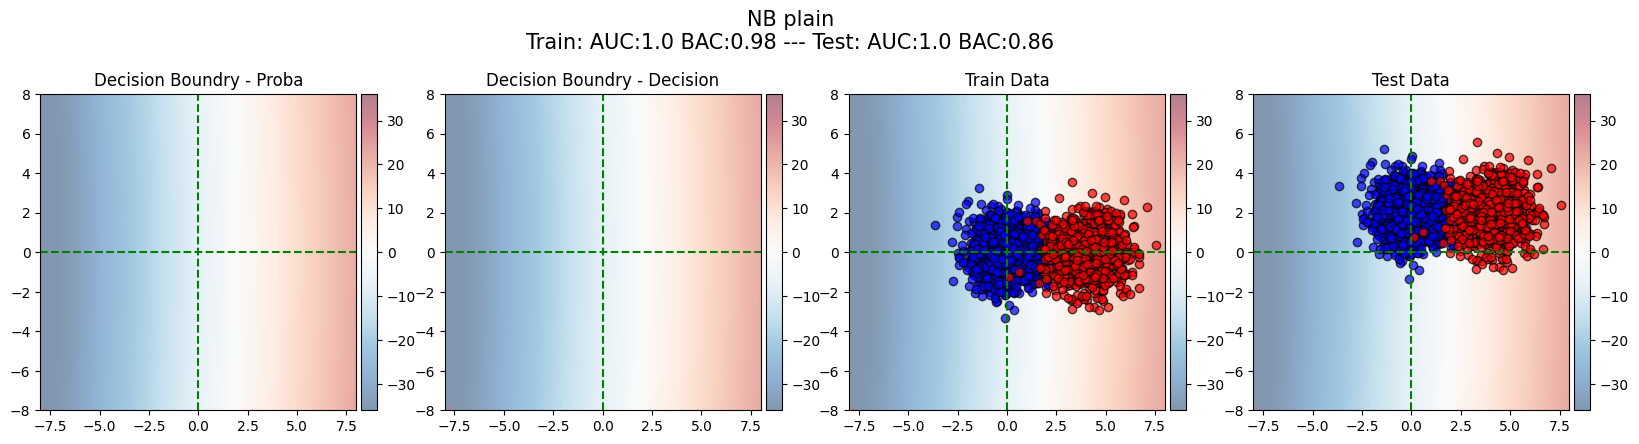

35.99680581798099 23.73845512456424 35.99680581798099
39.08099427465304 23.738451893108675 39.08099427465304
39.08099427465304 23.738451893108675 39.08099427465304
39.08099427465304 23.738451893108675 39.08099427465304


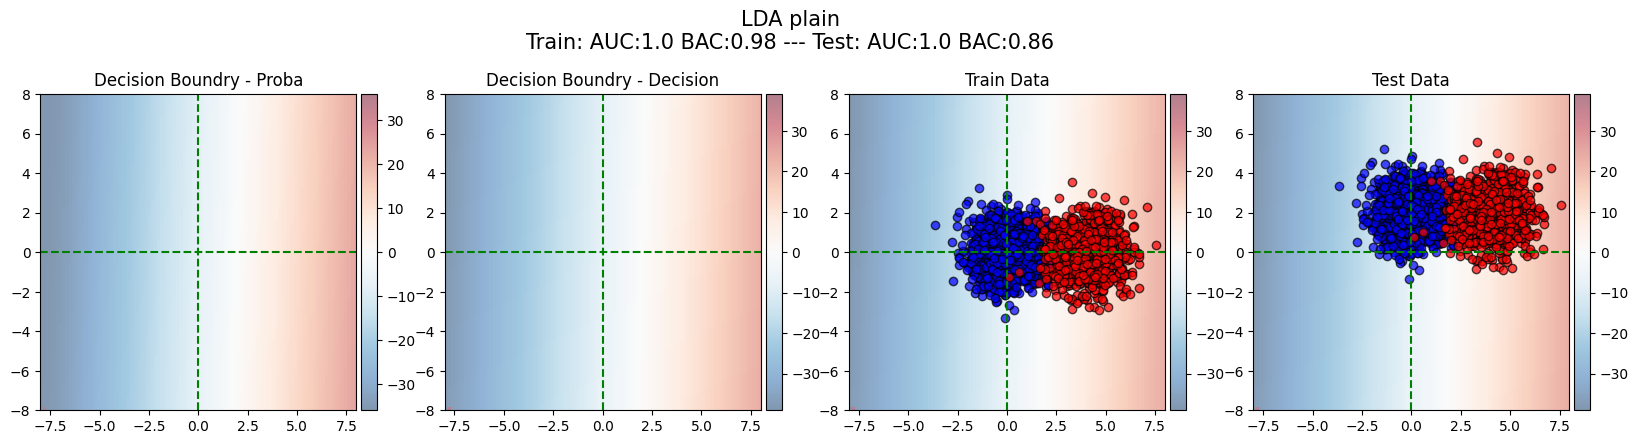

4.056001142543069 2.463667364568917 4.056001142543069
4.056001142543069 2.463667364568917 4.056001142543069
4.056001142543069 2.463667364568917 4.056001142543069
4.056001142543069 2.463667364568917 4.056001142543069


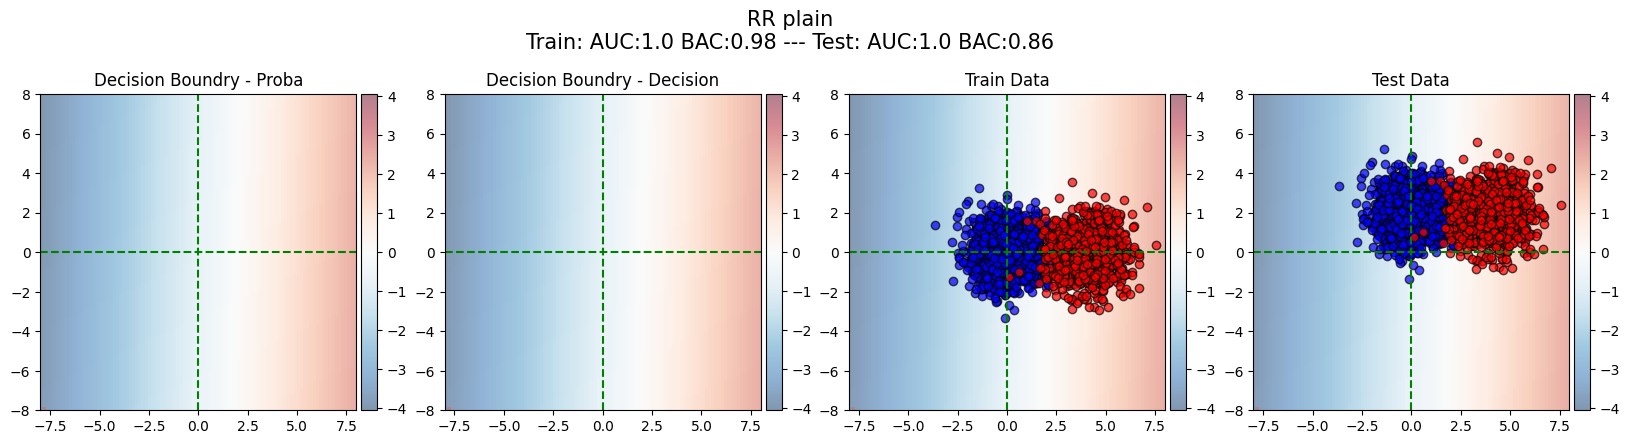

In [5]:
for model_s, result in zip(model_settings, results):
    visualize_decicion_boundary(model_s["display_name"], settings, result, train_sets, test_sets)